In [1]:
import os
import re
import math
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from glob import glob
from tools.settings import *
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tools.train_val_test_spliter import split
import collections
from collections import Counter

In [40]:
split()

Splitting the ginen dataset into Train Test=0.2 Validation=0.2
Done


In [2]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))

In [3]:
train.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\death/death_38.mp4,death
1,E:/Project 103/Trimmed Data\kill/Kill_27.mp4,kill
2,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
3,E:/Project 103/Trimmed Data\smoke/smoke_37 .mp4,smoke
4,E:/Project 103/Trimmed Data\kill/Kill_43.mp4,kill


In [4]:
test.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\kill/Kill_32.mp4,kill
1,E:/Project 103/Trimmed Data\smoke/smoke_106 .mp4,smoke
2,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
3,E:/Project 103/Trimmed Data\smoke/smoke_55 .mp4,smoke
4,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction


In [5]:
val.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\death/death_81.mp4,death
1,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
2,E:/Project 103/Trimmed Data\kill/Kill_37.mp4,kill
3,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
4,E:/Project 103/Trimmed Data\smoke/smoke_13 .mp4,smoke


In [6]:
print(train.shape)
print(test.shape)
print(val.shape)

(254, 2)
(81, 2)
(81, 2)


In [7]:
print(test)

                                            Video_url    action
0        E:/Project 103/Trimmed Data\kill/Kill_32.mp4      kill
1    E:/Project 103/Trimmed Data\smoke/smoke_106 .mp4     smoke
2   E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
3     E:/Project 103/Trimmed Data\smoke/smoke_55 .mp4     smoke
4   E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
..                                                ...       ...
76  E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
77    E:/Project 103/Trimmed Data\smoke/smoke_54 .mp4     smoke
78     E:/Project 103/Trimmed Data\smoke/smoke_7 .mp4     smoke
79       E:/Project 103/Trimmed Data\kill/Kill_51.mp4      kill
80     E:/Project 103/Trimmed Data\death/death_36.mp4     death

[81 rows x 2 columns]


In [8]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [9]:
convert_to_frame(train, train_frames_path_name)

100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [02:36<00:00,  1.62it/s]

Successfully Converted


In [10]:
convert_to_frame(val, val_frames_path_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:01<00:00,  1.33it/s]

Successfully Converted


In [11]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [12]:
create_paths_csv(train_frames_path, train_frames_path_name)

E:/Project 103/Trimmed Data\train_frames.csv


In [13]:
create_paths_csv(val_frames_path, val_frames_path_name)

E:/Project 103/Trimmed Data\val_frames.csv


In [14]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image

,image,action
0,E:/Project 103/Trimmed Data\train_frames\death...,death
1,E:/Project 103/Trimmed Data\train_frames\death...,death
2,E:/Project 103/Trimmed Data\train_frames\death...,death
3,E:/Project 103/Trimmed Data\train_frames\death...,death
4,E:/Project 103/Trimmed Data\train_frames\death...,death
...,...,...
737,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
738,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
739,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
740,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke


In [15]:
print(train_image.shape)

(742, 2)


In [16]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image

,image,action
0,E:/Project 103/Trimmed Data\val_frames\death_1...,death
1,E:/Project 103/Trimmed Data\val_frames\death_1...,death
2,E:/Project 103/Trimmed Data\val_frames\death_1...,death
3,E:/Project 103/Trimmed Data\val_frames\death_2...,death
4,E:/Project 103/Trimmed Data\val_frames\death_2...,death
...,...,...
242,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
243,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
244,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
245,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke


In [17]:
print(val_image.shape)

(247, 2)


In [18]:
action_values = list(train_image['action'].unique())
action_values

['death', 'kill', 'NoAction', 'smoke']

In [19]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [20]:
create_class_columns(train_image)
train_image.head()

,image,death,kill,NoAction,smoke
0,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
1,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
2,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
3,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
4,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0


In [21]:
create_class_columns(val_image)
val_image.head()

,image,death,kill,NoAction,smoke
0,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
1,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
2,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
3,E:/Project 103/Trimmed Data\val_frames\death_2...,1,0,0,0
4,E:/Project 103/Trimmed Data\val_frames\death_2...,1,0,0,0


In [22]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(224,224,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

# VGG16

In [23]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 742/742 [00:21<00:00, 33.98it/s]


(742, 224, 224, 3)


In [24]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:07<00:00, 32.80it/s]


(247, 224, 224, 3)


In [25]:
#'warning'
X_train_set_copy = X_train
X_val_set_copy = X_val

In [247]:
X_train = X_train_set_copy
X_val = X_val_set_copy

In [26]:
X_train.shape

(742, 224, 224, 3)

In [27]:
X_val.shape

(247, 224, 224, 3)

In [28]:
y_train.head()

,death,kill,NoAction,smoke
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_vgg16 = VGG16(weights='imagenet', include_top=False)

In [30]:
X_train = base_model_vgg16.predict(X_train)
X_train.shape

(742, 7, 7, 512)

In [31]:
X_val = base_model_vgg16.predict(X_val)
X_val.shape

(247, 7, 7, 512)

In [32]:
#'warning'
X_train_copy_vgg16 = X_train
X_val_copy_vgg16 = X_val

In [254]:
X_train = X_train_copy_vgg16
X_val = X_val_copy_vgg16

In [33]:
X_train = X_train.reshape(X_train.shape[0], 7*7*512)
X_val = X_val.reshape(X_val.shape[0], 7*7*512)

In [34]:
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(742, 25088)
(247, 25088)


In [35]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5

In [36]:
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_vgg16_final2_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [37]:
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=150)

Epoch 1/20
5/5 [==============================] - 5s 678ms/step - loss: 1.3934 - accuracy: 0.2856 - val_loss: 1.2442 - val_accuracy: 0.5587
Epoch 2/20
5/5 [==============================] - 1s 167ms/step - loss: 1.3252 - accuracy: 0.3694 - val_loss: 1.1022 - val_accuracy: 0.5668
Epoch 3/20
5/5 [==============================] - 1s 170ms/step - loss: 1.1566 - accuracy: 0.4860 - val_loss: 0.9692 - val_accuracy: 0.6356
Epoch 4/20
5/5 [==============================] - 1s 170ms/step - loss: 0.9650 - accuracy: 0.5763 - val_loss: 0.8623 - val_accuracy: 0.6721
Epoch 5/20
5/5 [==============================] - 1s 186ms/step - loss: 0.8380 - accuracy: 0.6621 - val_loss: 0.8093 - val_accuracy: 0.6397
Epoch 6/20
5/5 [==============================] - 1s 171ms/step - loss: 0.6667 - accuracy: 0.7464 - val_loss: 0.7817 - val_accuracy: 0.6397
Epoch 7/20
5/5 [==============================] - 1s 177ms/step - loss: 0.5723 - accuracy: 0.7785 - val_loss: 0.7487 - val_accuracy: 0.6640
Epoch 8/20
5/5 [====

In [ ]:
model.load_weights("weight_vgg16_final1_2.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

In [38]:
from scipy import stats as s
predict_vgg16 = []
actual = []
dict_vgg16 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    prediction_images_copy = prediction_images
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_vgg16.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_vgg16[video_name] = prediction_test
        #print(prediction_test)
        #print(action)
        #print(video_name)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_vgg16.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:38<00:00,  1.96s/it]


In [39]:
print(dict_vgg16)

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}


In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_vgg16, actual)*100

91.35802469135803

In [41]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_vgg16, actual)*100
precision = precision_score(actual, predict_vgg16, average=None)
f1_score = f1_score(actual, predict_vgg16, average=None)
recall = recall_score(actual, predict_vgg16, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  91.35802469135803
Precision:  [0.86363636 0.94444444 0.9        0.95238095]
F1_score:  [0.9047619  0.89473684 0.9        0.95238095]
Recall:  [0.95       0.85       0.9        0.95238095]


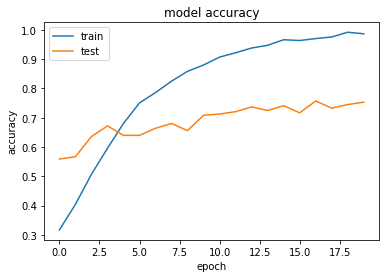

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

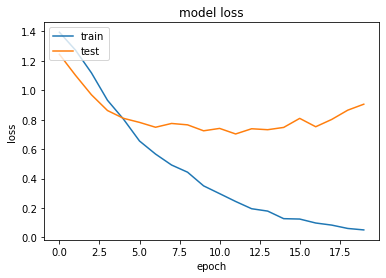

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(actual, predict_vgg16, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 3 17]]

 [[59  2]
  [ 2 18]]

 [[58  3]
  [ 1 19]]

 [[59  1]
  [ 1 20]]]


In [45]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=30):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

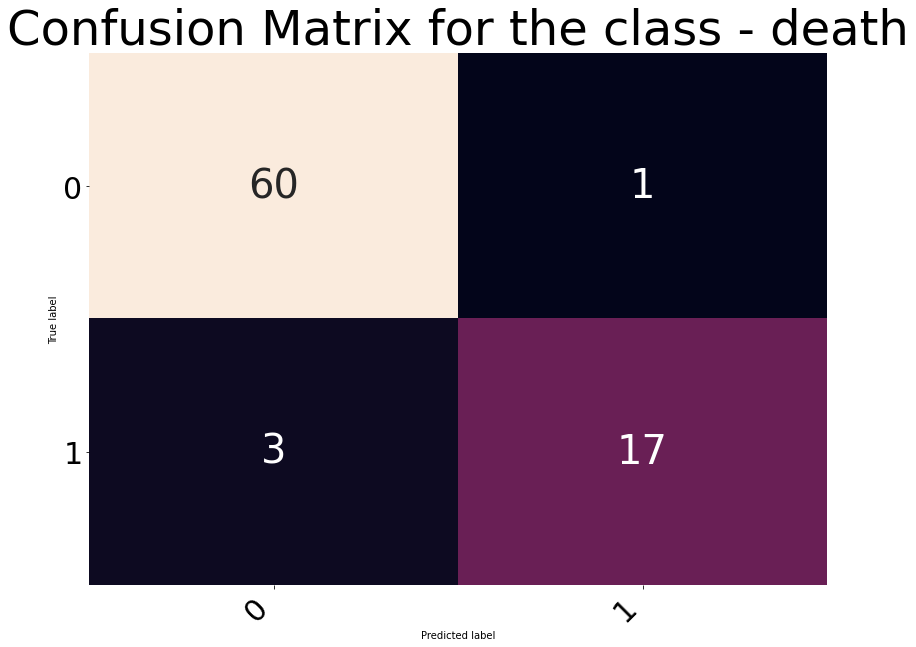

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

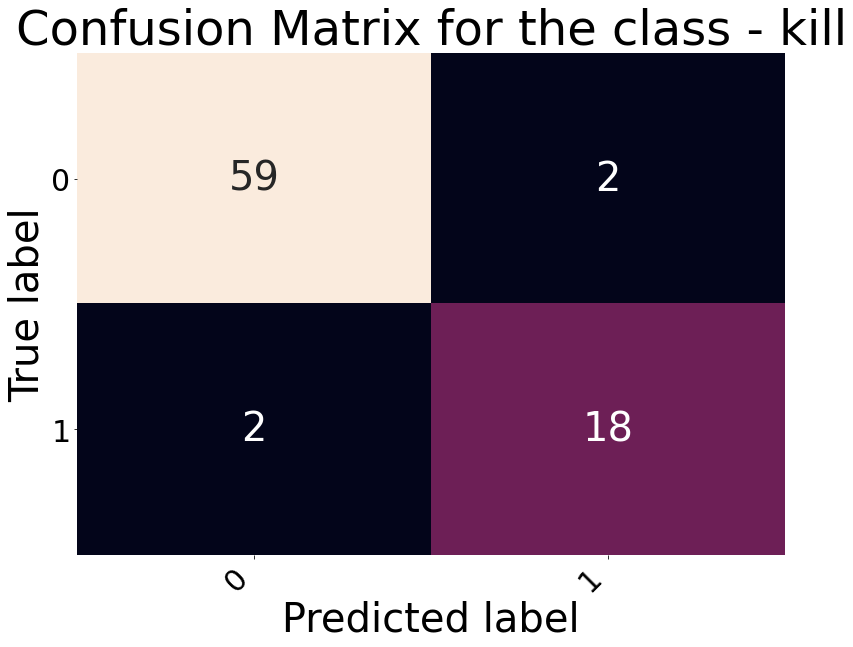

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

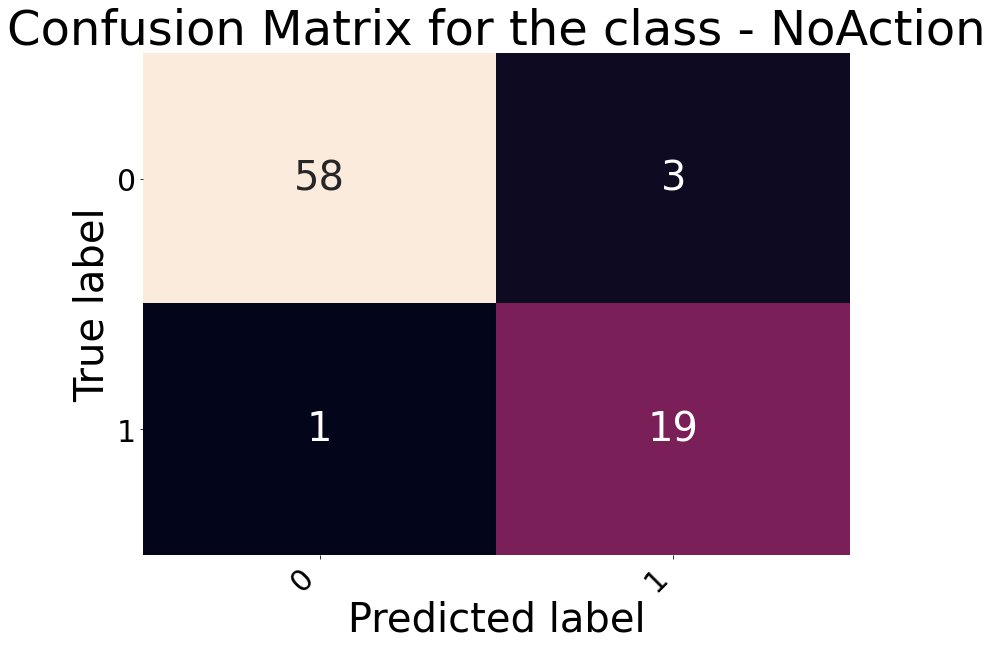

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

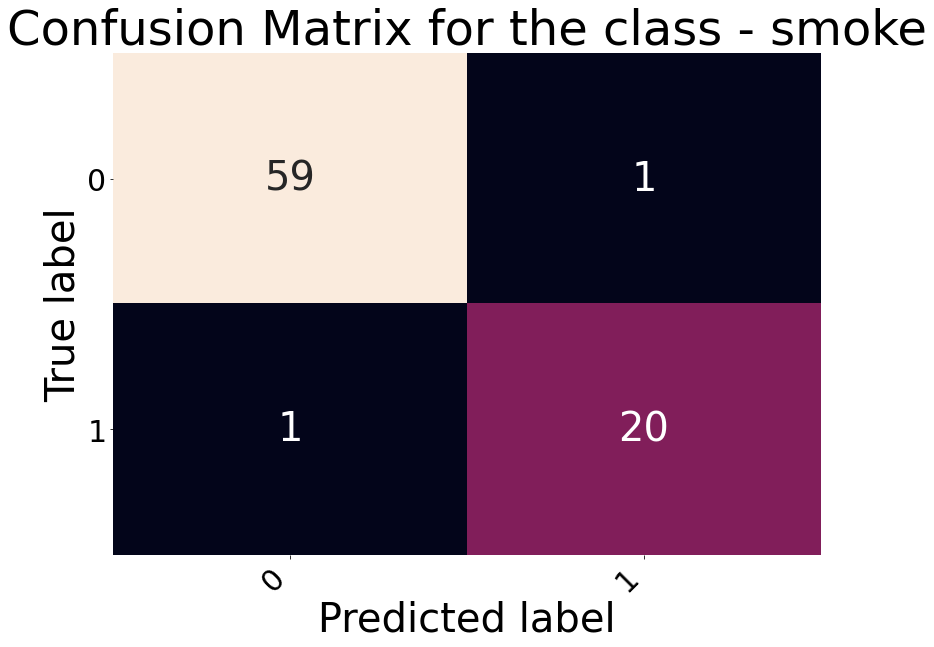

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Xception

In [50]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [51]:
from tensorflow.keras.applications.xception import Xception
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_xception = Xception(weights='imagenet', include_top=False)

In [52]:
X_train = base_model_xception.predict(X_train)
X_train.shape

(742, 7, 7, 2048)

In [53]:
X_val = base_model_xception.predict(X_val)
X_val.shape

(247, 7, 7, 2048)

In [54]:
#'warning'
X_train_copy_xception = X_train
X_val_copy_xception = X_val

In [302]:
X_train = X_train_copy_xception
X_val = X_val_copy_xception

In [55]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)
X_val = X_val.reshape(X_val.shape[0], 7*7*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_xception_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_xception=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=150)

(742, 100352)
(247, 100352)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)           

In [56]:
from scipy import stats as s
predict_xception = []
actual = []
dict_xception = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_xception.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_xception[video_name] = prediction_test
        
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_xception.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:50<00:00,  1.37s/it]


In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_xception, actual)*100

88.88888888888889

In [58]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_xception, actual)*100
precision = precision_score(actual, predict_xception, average=None)
f1_score = f1_score(actual, predict_xception, average=None)
recall = recall_score(actual, predict_xception, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  88.88888888888889
Precision:  [1.         0.89473684 0.81818182 0.86956522]
F1_score:  [0.91891892 0.87179487 0.85714286 0.90909091]
Recall:  [0.85       0.85       0.9        0.95238095]


In [59]:
print(dict_xception)
print(dict_vgg16)
#print(dict_inceptionv3)
#print(dict_inceptionresnetv2)

{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}
{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}


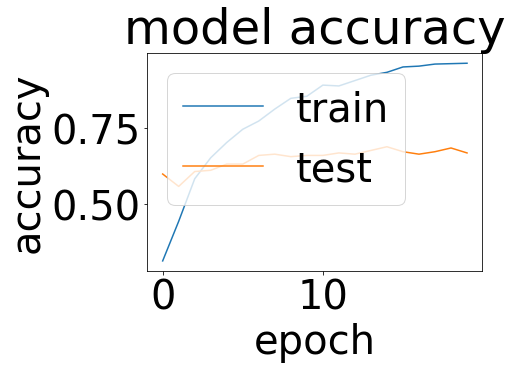

In [60]:
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

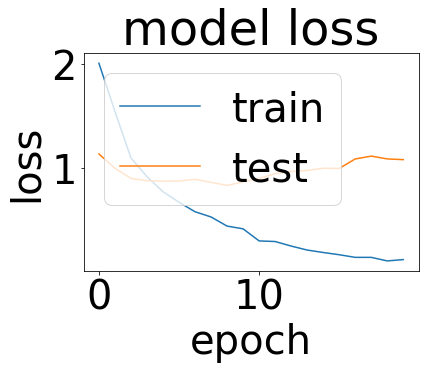

In [61]:
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_xception, labels=action_values)

print(confusion_matrix)

[[[59  2]
  [ 3 17]]

 [[57  4]
  [ 2 18]]

 [[61  0]
  [ 3 17]]

 [[57  3]
  [ 1 20]]]


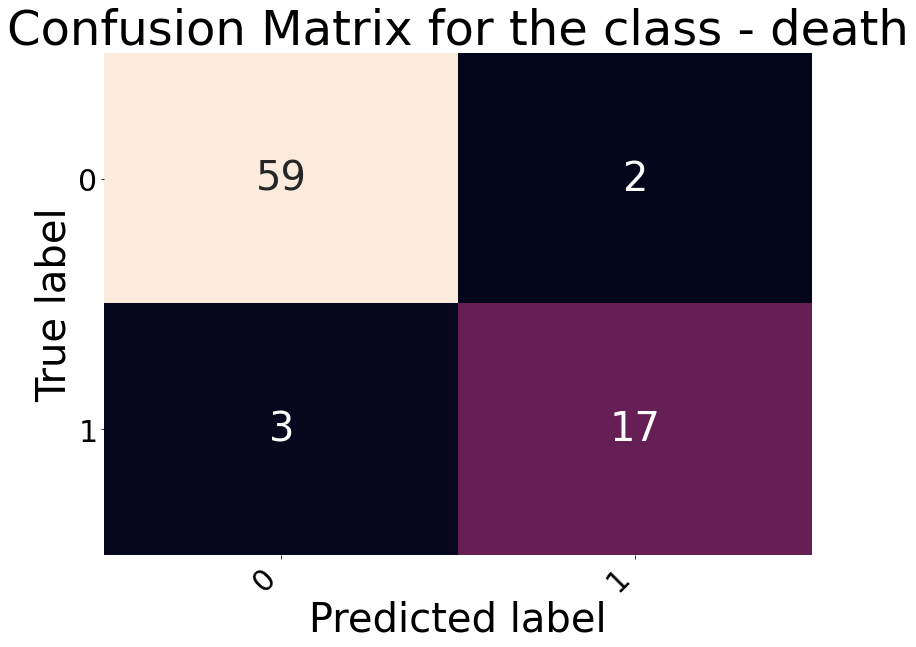

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

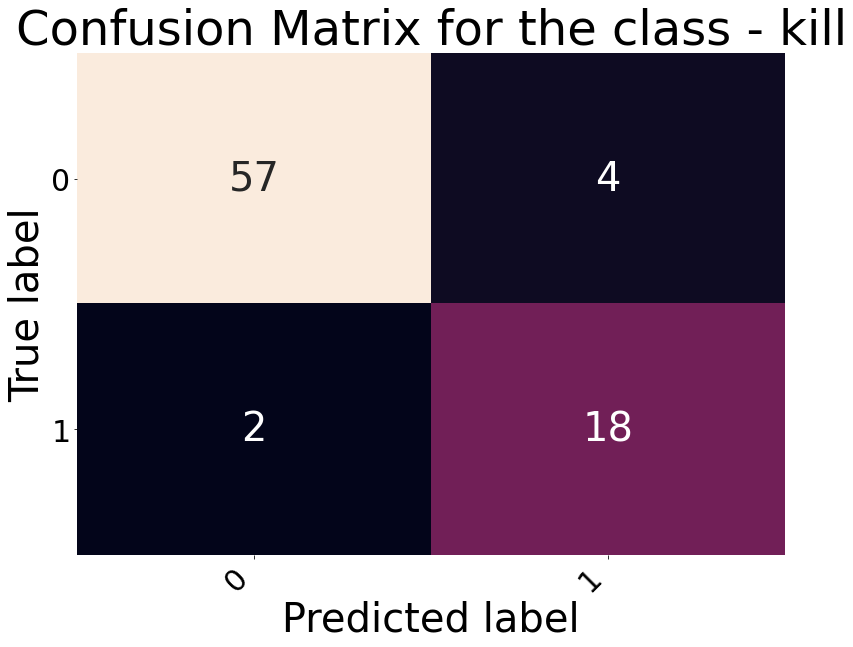

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

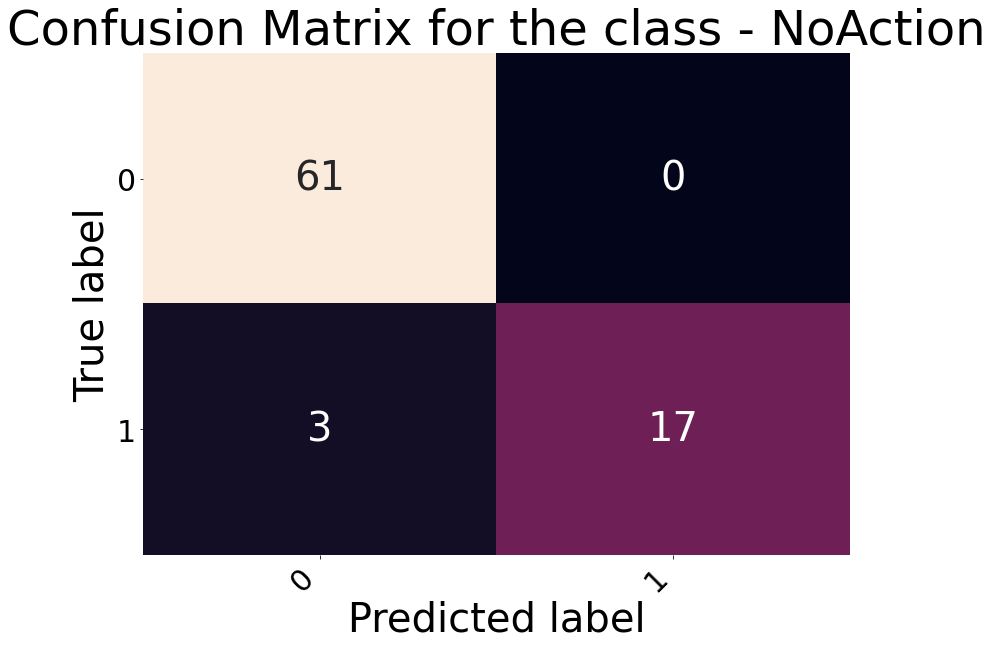

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

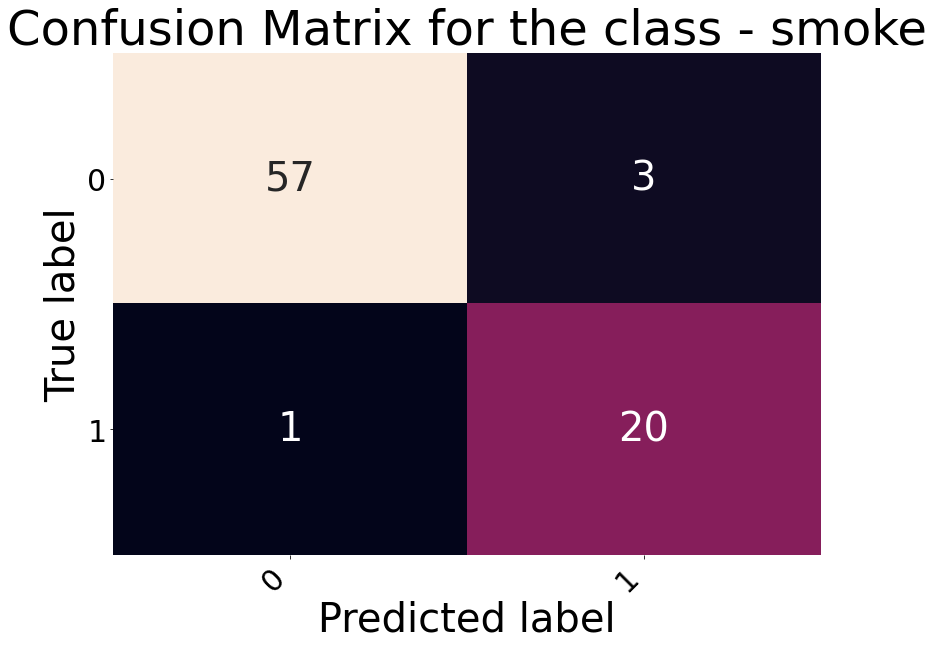

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# InceptionV3


In [67]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [68]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_inception = InceptionV3(weights='imagenet', include_top=False)

In [69]:
X_train = base_model_inception.predict(X_train)
X_val = base_model_inception.predict(X_val)
X_val.shape

print(X_train.shape)
print(X_val.shape)

(742, 5, 5, 2048)
(247, 5, 5, 2048)


In [70]:
#'warning'
X_train_copy_inception = X_train
X_val_copy_inception = X_val

In [309]:
X_train = X_train_copy_inception
X_val = X_val_copy_inception

In [71]:
X_train = X_train.reshape(X_train.shape[0], 5*5*2048)
X_val = X_val.reshape(X_val.shape[0], 5*5*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51200,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_inception_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_inception=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=150)

(742, 51200)
(247, 51200)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)            

In [72]:
from scipy import stats as s
predict_inception = []
actual = []
dict_inceptionv3 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_inception.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 5*5*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_inceptionv3[video_name] = prediction_test
    
    predict_inception.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:31<00:00,  1.12s/it]


In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_inception, actual)*100

90.12345679012346

In [74]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_inception, actual)*100
precision = precision_score(actual, predict_inception, average=None)
f1_score = f1_score(actual, predict_inception, average=None)
recall = recall_score(actual, predict_inception, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  90.12345679012346
Precision:  [0.94444444 0.9        0.9        0.86956522]
F1_score:  [0.89473684 0.9        0.9        0.90909091]
Recall:  [0.85       0.9        0.9        0.95238095]


In [75]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}
{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_55': 'smoke', 'death_45': 'NoAction', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'smoke_7 ': 'death'}


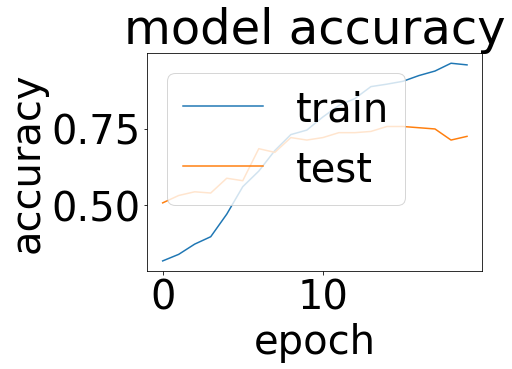

In [76]:
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

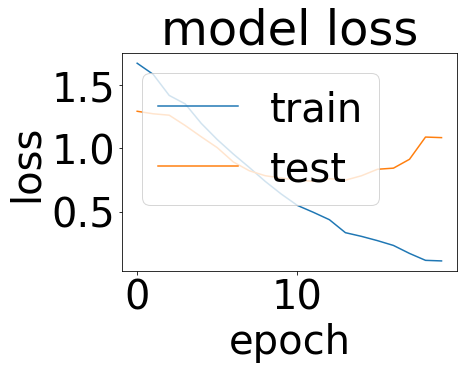

In [77]:
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("weight_inception_final1_3.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

In [78]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_inception, labels=action_values)

print(confusion_matrix)

[[[59  2]
  [ 2 18]]

 [[59  2]
  [ 2 18]]

 [[60  1]
  [ 3 17]]

 [[57  3]
  [ 1 20]]]


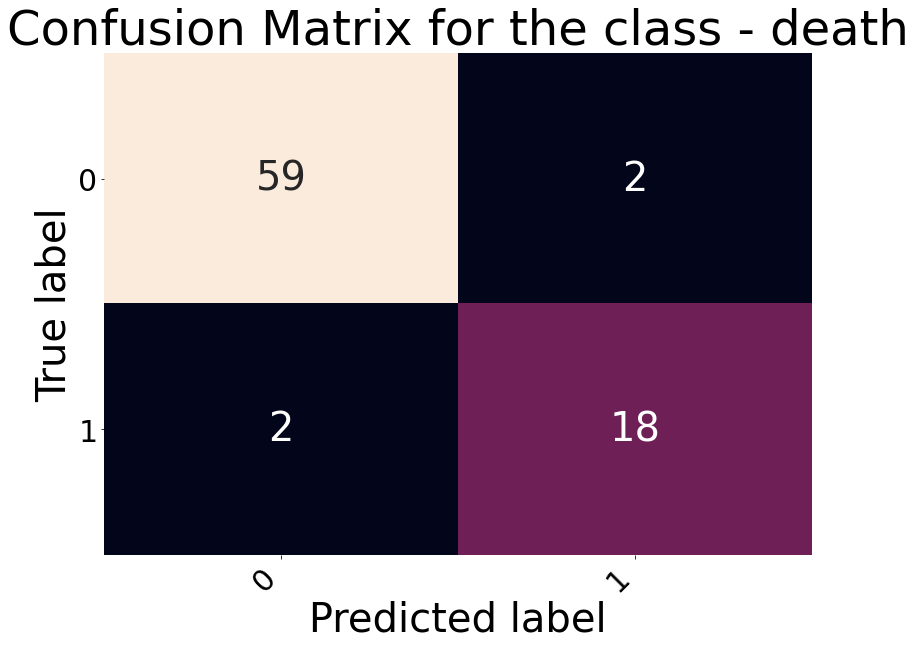

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

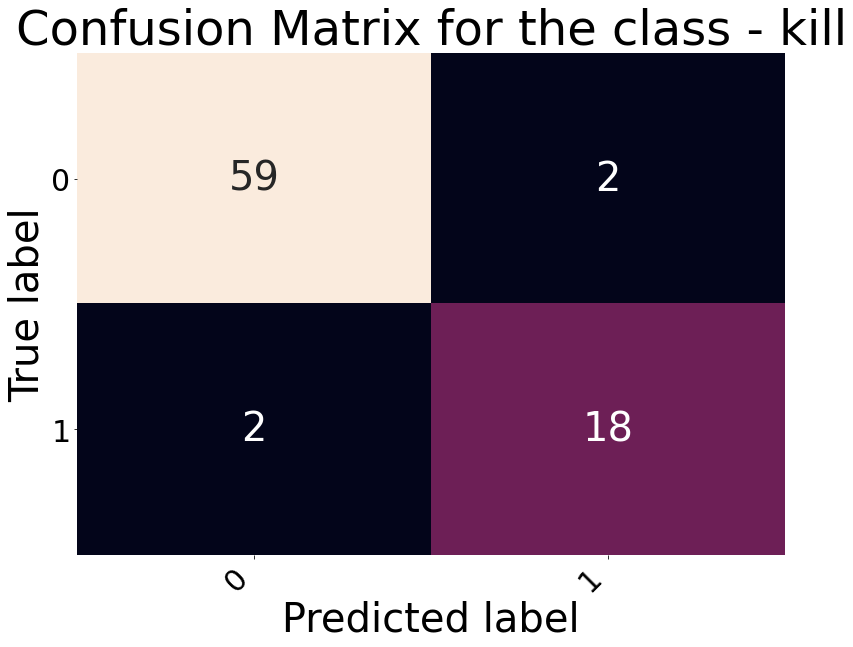

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

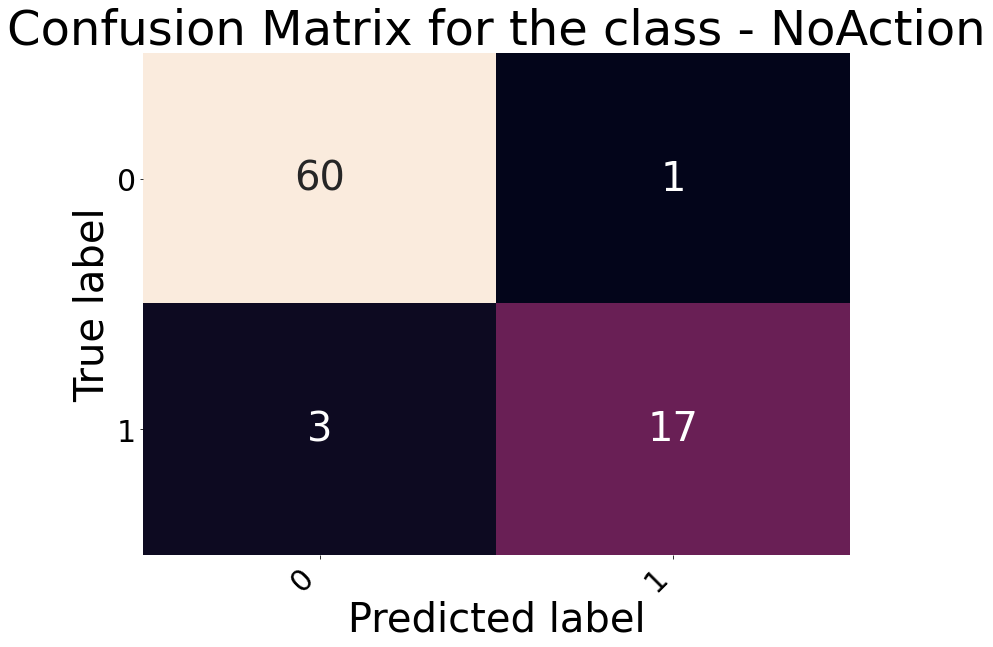

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

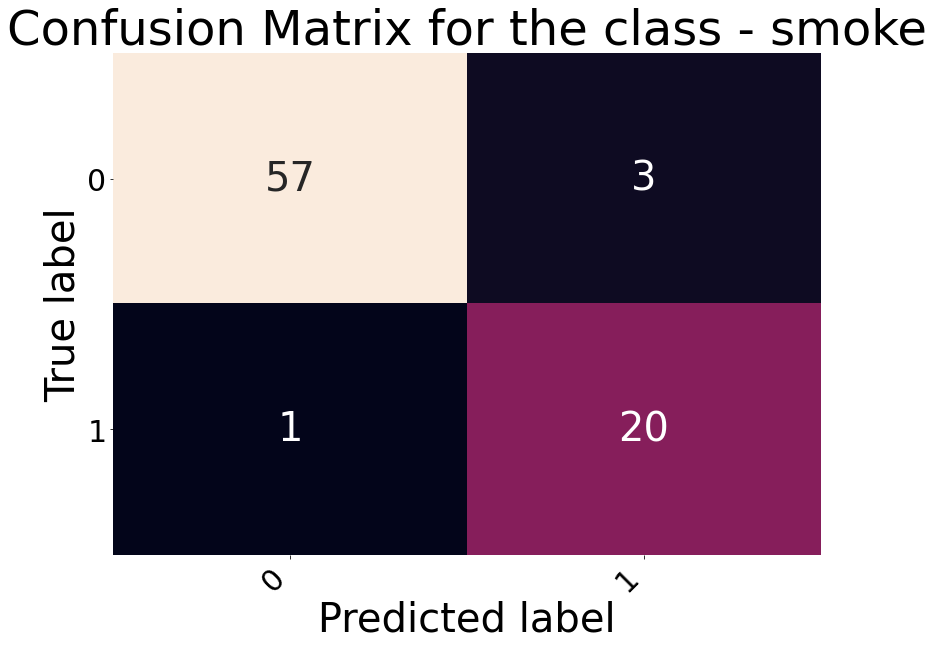

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# InceptionResnetV2

In [83]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [84]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False)

In [85]:
X_train = base_model_InceptionResNetV2.predict(X_train)
X_val = base_model_InceptionResNetV2.predict(X_val)
X_val.shape

print(X_train.shape)
print(X_val.shape)

(742, 5, 5, 1536)
(247, 5, 5, 1536)


In [86]:
#'warning'
X_train_copy_inceptionresnet = X_train
X_val_copy_inceptionresnet = X_val

In [316]:
X_train = X_train_copy_inceptionresnet
X_val = X_val_copy_inceptionresnet

In [87]:
X_train = X_train.reshape(X_train.shape[0], 5*5*1536)
X_val = X_val.reshape(X_val.shape[0], 5*5*1536)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(38400,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_inceptionresnet_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_InceptionResNetV2=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[mcp_weight], 
                                    batch_size=150)

(742, 38400)
(247, 38400)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               19661312  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)            

In [88]:
from scipy import stats as s
predict_inceptionresnet = []
actual = []
dict_inceptionresnetv2 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_InceptionResNetV2.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 5*5*1536)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_inceptionresnetv2[video_name] = prediction_test
    
    predict_inceptionresnet.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:47<00:00,  1.33s/it]


In [89]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)
print(dict_inceptionresnetv2)

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}
{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_55': 'smoke', 'death_45': 'NoAction', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'death_37': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_10 ': 'kill', 'smoke_25 ': 'NoAction', 'death_16': 'kill', 'death_66': 'NoAction', 'smoke_7 ': 'kill'}


In [90]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_inceptionresnet, actual)*100
precision = precision_score(actual, predict_inceptionresnet, average=None)
f1_score = f1_score(actual, predict_inceptionresnet, average=None)
recall = recall_score(actual, predict_inceptionresnet, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  83.9506172839506
Precision:  [0.86363636 1.         0.72       0.85714286]
F1_score:  [0.9047619  0.78787879 0.8        0.85714286]
Recall:  [0.95       0.65       0.9        0.85714286]


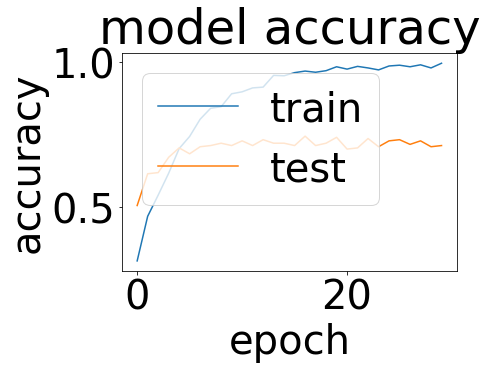

In [91]:
plt.plot(history_InceptionResNetV2.history['accuracy'])
plt.plot(history_InceptionResNetV2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

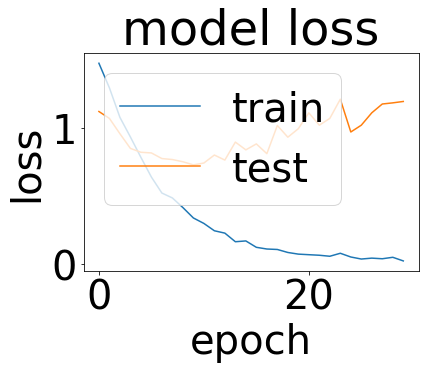

In [92]:
plt.plot(history_InceptionResNetV2.history['loss'])
plt.plot(history_InceptionResNetV2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_inceptionresnet, labels=action_values)

print(confusion_matrix)

[[[61  0]
  [ 7 13]]

 [[54  7]
  [ 2 18]]

 [[58  3]
  [ 1 19]]

 [[57  3]
  [ 3 18]]]


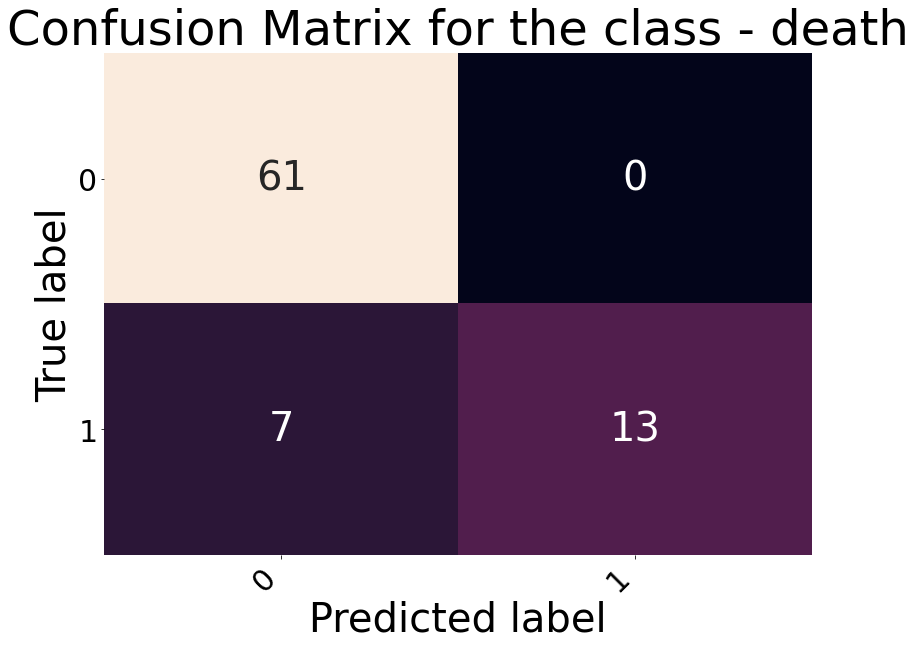

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

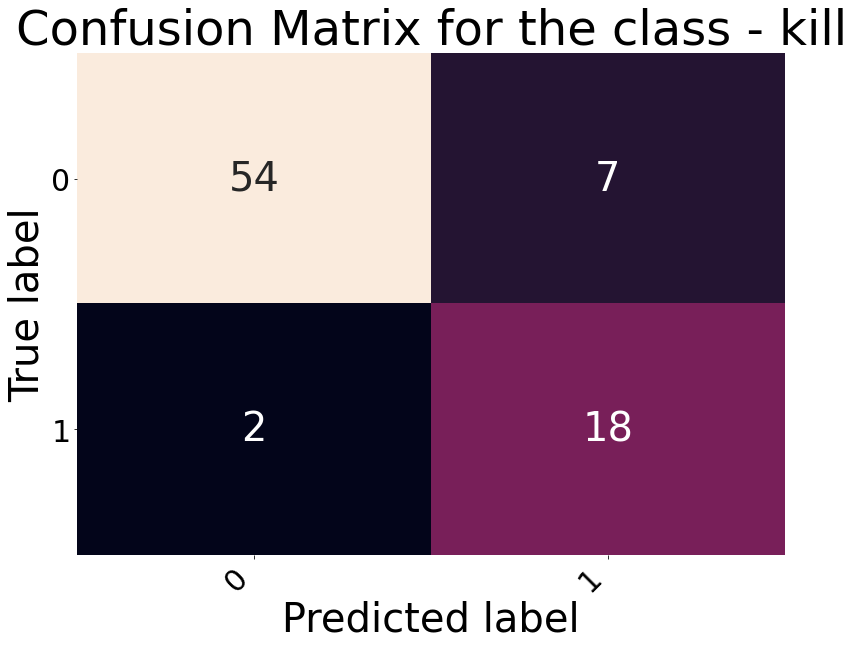

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

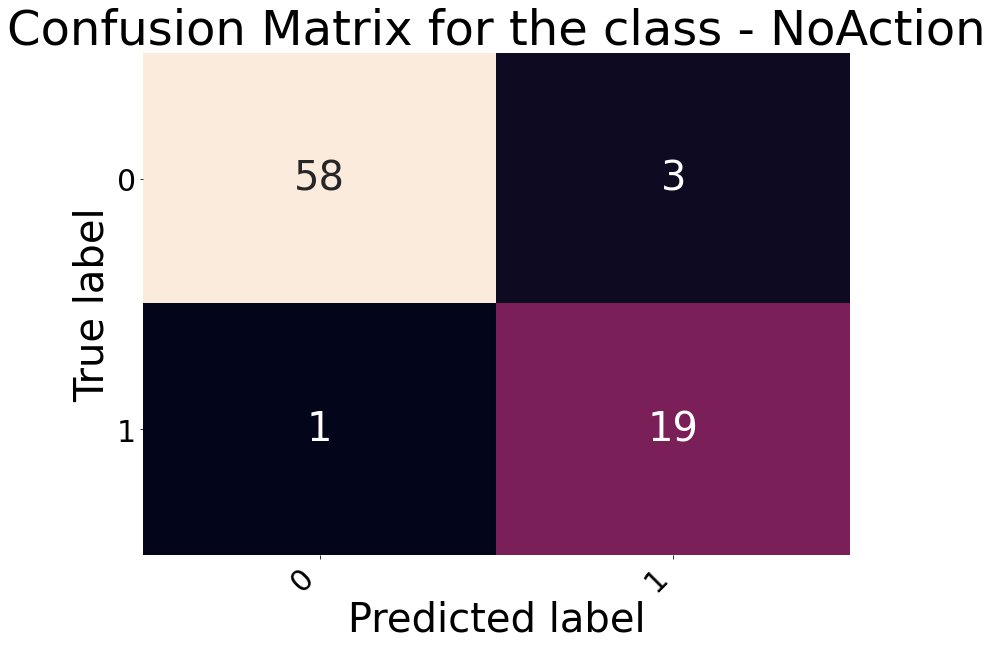

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

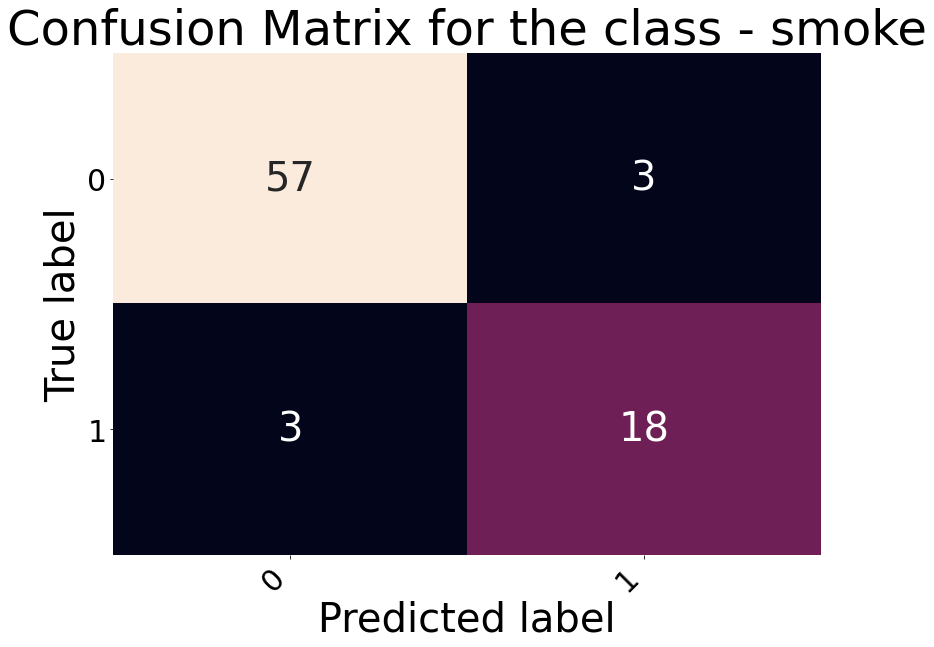

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Resnet152vV2


In [98]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [99]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of thresnet_v2is model so that we can tune it as per our need.
'''
base_model_resnet_v2 = ResNet152V2(weights='imagenet', include_top=False)

In [100]:
X_train = base_model_resnet_v2.predict(X_train)
X_val = base_model_resnet_v2.predict(X_val)

print(X_train.shape)
print(X_val.shape)

(742, 7, 7, 2048)
(247, 7, 7, 2048)


In [101]:
#'warning'
X_train_copy_ResNet152V2 = X_train
X_val_copy_ResNet152V2 = X_val

In [323]:
X_train = X_train_copy_ResNet152V2
X_val = X_val_copy_ResNet152V2

In [102]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)
X_val = X_val.reshape(X_val.shape[0], 7*7*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_X_val_copy_ResNet152V2_final1_2.hdf5', save_best_only=True, monitor='val_loss', 
                             mode='min')

history_resnet_v2=model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=150)

(742, 100352)
(247, 100352)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)          

In [103]:
from scipy import stats as s
predict_resnet = []
actual = []
dict_ResNet152V2 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_resnet_v2.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_ResNet152V2[video_name] = prediction_test
        
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_resnet.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:38<00:00,  1.96s/it]


In [104]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_resnet, actual)*100

95.06172839506173

In [105]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_resnet, actual)*100
precision = precision_score(actual, predict_resnet, average=None)
f1_score = f1_score(actual, predict_resnet, average=None)
recall = recall_score(actual, predict_resnet, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  95.06172839506173
Precision:  [1.         0.94736842 0.9047619  0.95454545]
F1_score:  [0.97435897 0.92307692 0.92682927 0.97674419]
Recall:  [0.95 0.9  0.95 1.  ]


In [106]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)
print(dict_inceptionresnetv2)
print(dict_ResNet152V2)

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}
{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_55': 'smoke', 'death_45': 'NoAction', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'death_37': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_10 ': 'kill', 'smoke_25 ': 'NoAction', 'death_16': 'kill', 'death_66': 'NoAction', 'smoke_7 ': 'kill'}
{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_9': 'smoke', 'death_16': 'kill'}


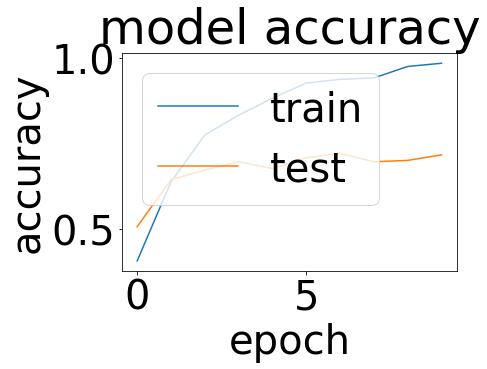

In [107]:
plt.plot(history_resnet_v2.history['accuracy'])
plt.plot(history_resnet_v2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

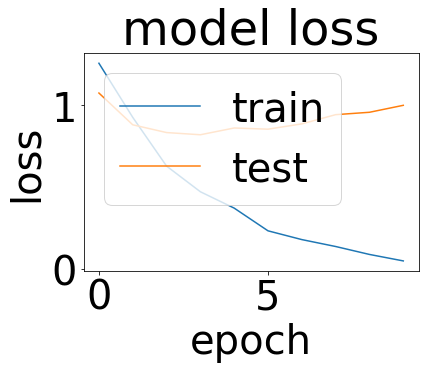

In [108]:
plt.plot(history_resnet_v2.history['loss'])
plt.plot(history_resnet_v2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_resnet, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 2 18]]

 [[59  2]
  [ 1 19]]

 [[61  0]
  [ 1 19]]

 [[59  1]
  [ 0 21]]]


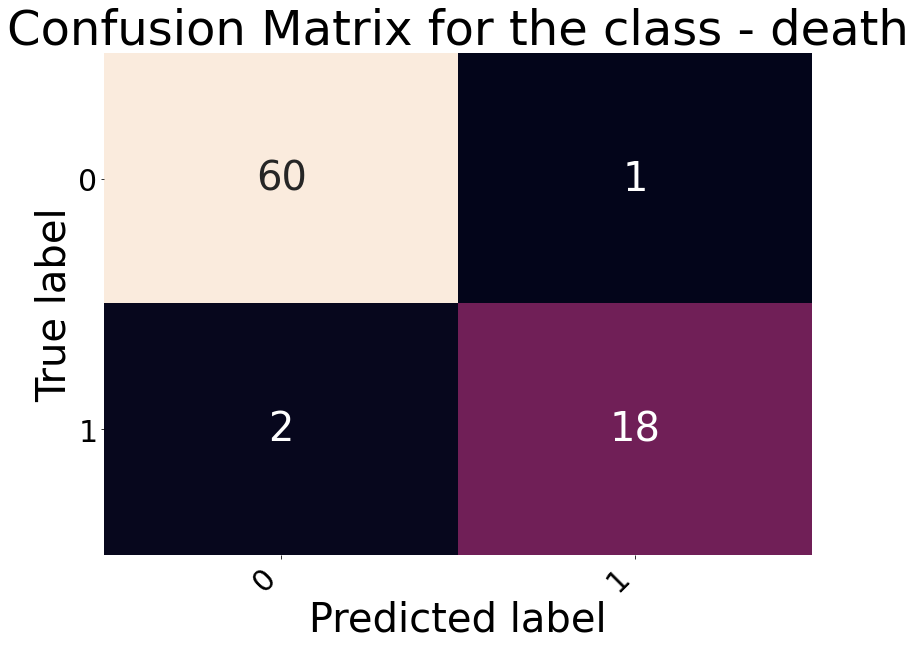

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

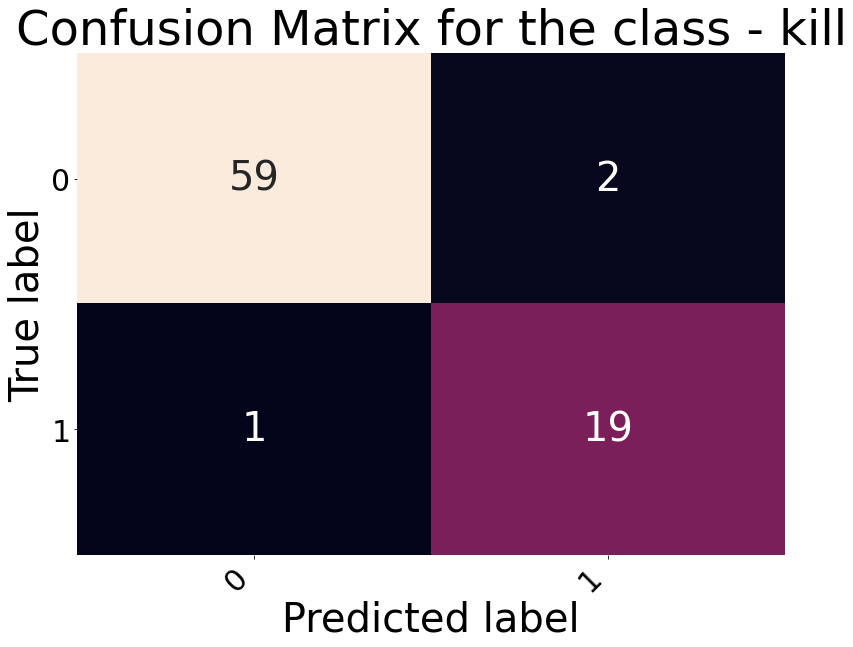

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

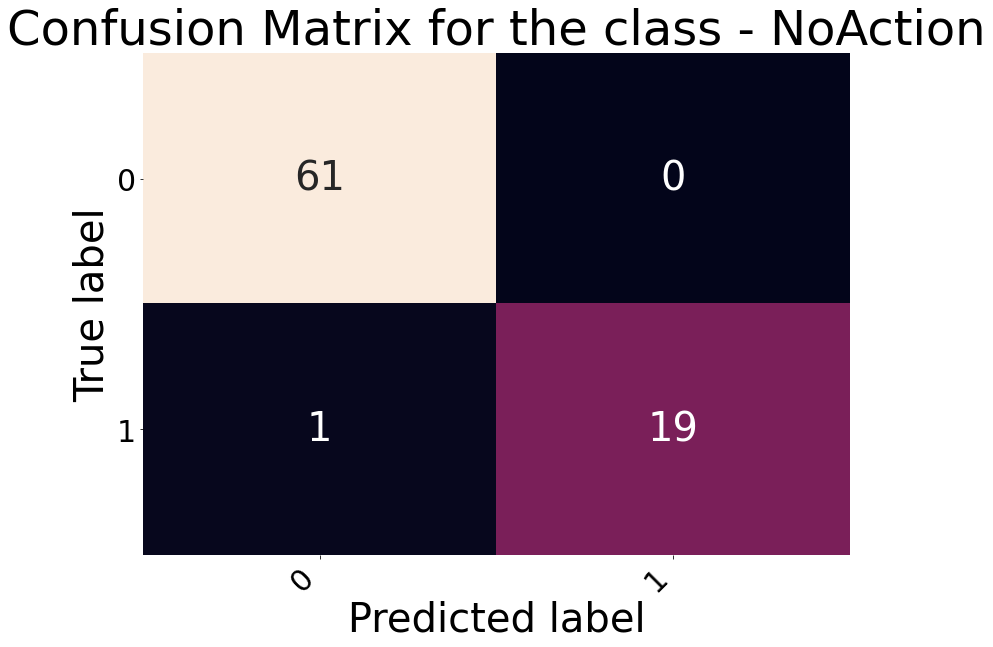

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

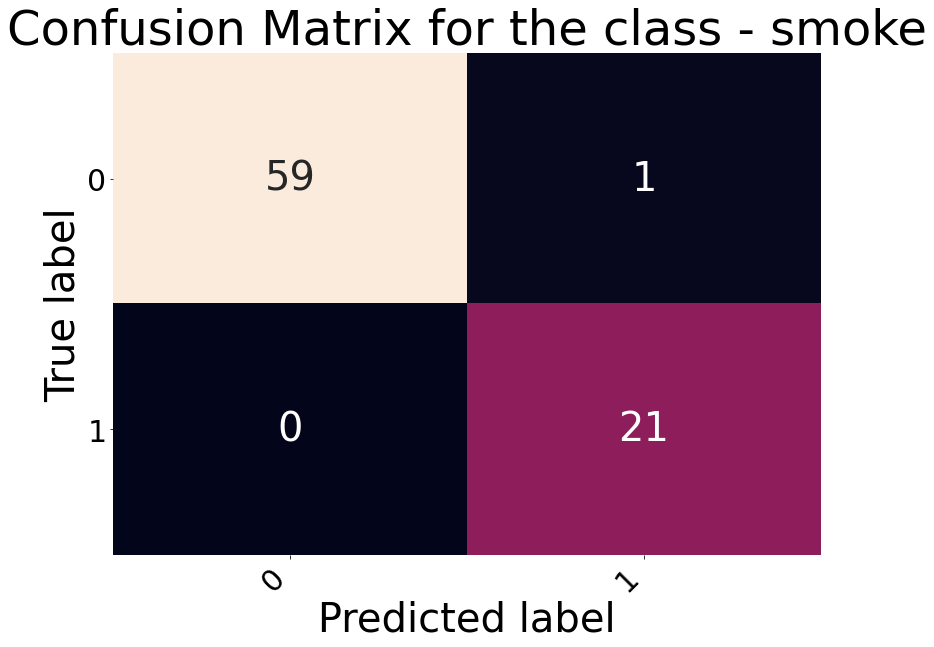

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Fault Data Identification

In [114]:
print(dict_xception)
print('')
print(dict_vgg16)
print('')
print(dict_inceptionv3)
print('')
print(dict_inceptionresnetv2)
print('')
print(dict_ResNet152V2)

{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}

{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_55': 'smoke', 'death_45': 'NoAction', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'smoke_7 ': 'death'}

{'death_17': 'kill', 'death_37': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_10 ': 'kill', 'smoke_25 ': 'NoAction', 'death_16': 'kill', 'death_66': 'NoAction', 'smoke_7 ': 'kill'}

{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_9': 'smoke', 'death_16': 'kill'}


In [115]:
from collections import Counter

#key_list_vgg16 = list(dict_vgg16.keys())
key_list_xception = list(dict_xception.keys())
key_list_inceptionv3 = list(dict_inceptionv3.keys())
key_list_inceptionresnetv2 = list(dict_inceptionresnetv2.keys())
key_list_ResNet152V2 = list(dict_ResNet152V2.keys())


#key_list = key_list_vgg16 + key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2
key_list = key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2

print(Counter(key_list))

Counter({'death_17': 4, 'Kill_4': 4, 'NoAction_9': 3, 'death_16': 3, 'smoke_7 ': 3, 'NoAction_102': 2, 'NoAction_55': 2, 'death_55': 1, 'NoAction_77': 1, 'Kill_89': 1, 'death_45': 1, 'Kill_22': 1, 'death_37': 1, 'death_33': 1, 'Kill_5': 1, 'death_42': 1, 'death_102': 1, 'smoke_10 ': 1, 'smoke_25 ': 1, 'death_66': 1})


In [116]:
key_list_vgg16 = list(dict_vgg16.keys())
print(key_list_vgg16)

['death_17', 'Kill_4', 'death_33', 'NoAction_9', 'smoke_10 ', 'death_16', 'Kill_89']


In [117]:
from collections import Counter

key_list_vgg16 = list(dict_vgg16.keys())
key_list_xception = list(dict_xception.keys())
key_list_inceptionv3 = list(dict_inceptionv3.keys())
key_list_inceptionresnetv2 = list(dict_inceptionresnetv2.keys())
key_list_ResNet152V2 = list(dict_ResNet152V2.keys())


key_list = key_list_vgg16 + key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2

print(Counter(key_list))

Counter({'death_17': 5, 'Kill_4': 5, 'NoAction_9': 4, 'death_16': 4, 'smoke_7 ': 3, 'death_33': 2, 'smoke_10 ': 2, 'Kill_89': 2, 'NoAction_102': 2, 'NoAction_55': 2, 'death_55': 1, 'NoAction_77': 1, 'death_45': 1, 'Kill_22': 1, 'death_37': 1, 'Kill_5': 1, 'death_42': 1, 'death_102': 1, 'smoke_25 ': 1, 'death_66': 1})


# Majority voting

In [118]:
majority_predict = []

for i in range(len(predict_vgg16)):
    
    a = [predict_vgg16[i], predict_xception[i], predict_inception[i], predict_inceptionresnet[i], predict_resnet[i]]
    
    most_common_item = max(a, key = a.count)
    majority_predict.append(most_common_item)
    
print(majority_predict)
print(len(majority_predict))
print(accuracy_score(majority_predict, actual)*100)

['kill', 'smoke', 'NoAction', 'smoke', 'NoAction', 'kill', 'smoke', 'death', 'kill', 'death', 'NoAction', 'death', 'death', 'NoAction', 'NoAction', 'NoAction', 'death', 'smoke', 'kill', 'NoAction', 'death', 'NoAction', 'kill', 'smoke', 'NoAction', 'death', 'NoAction', 'kill', 'smoke', 'NoAction', 'kill', 'kill', 'kill', 'smoke', 'smoke', 'smoke', 'kill', 'kill', 'death', 'kill', 'NoAction', 'smoke', 'smoke', 'NoAction', 'death', 'kill', 'smoke', 'death', 'smoke', 'death', 'smoke', 'smoke', 'smoke', 'NoAction', 'death', 'NoAction', 'smoke', 'NoAction', 'NoAction', 'death', 'smoke', 'NoAction', 'kill', 'death', 'smoke', 'kill', 'death', 'death', 'kill', 'kill', 'kill', 'kill', 'death', 'smoke', 'death', 'kill', 'NoAction', 'smoke', 'smoke', 'kill', 'death']
81
95.06172839506173


In [119]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(majority_predict, actual)*100
precision = precision_score(actual, majority_predict, average=None)
f1_score = f1_score(actual, majority_predict, average=None)
recall = recall_score(actual, majority_predict, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  95.06172839506173
Precision:  [1.         0.94736842 0.9047619  0.95454545]
F1_score:  [0.97435897 0.92307692 0.92682927 0.97674419]
Recall:  [0.95 0.9  0.95 1.  ]


In [120]:
confusion_matrix = multilabel_confusion_matrix(actual, majority_predict, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 2 18]]

 [[59  2]
  [ 1 19]]

 [[61  0]
  [ 1 19]]

 [[59  1]
  [ 0 21]]]


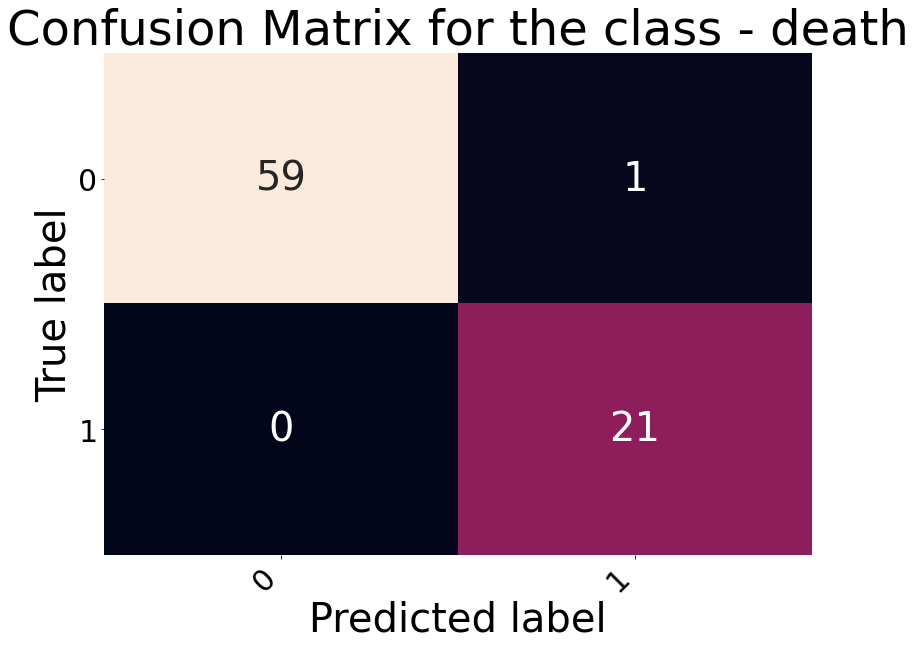

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

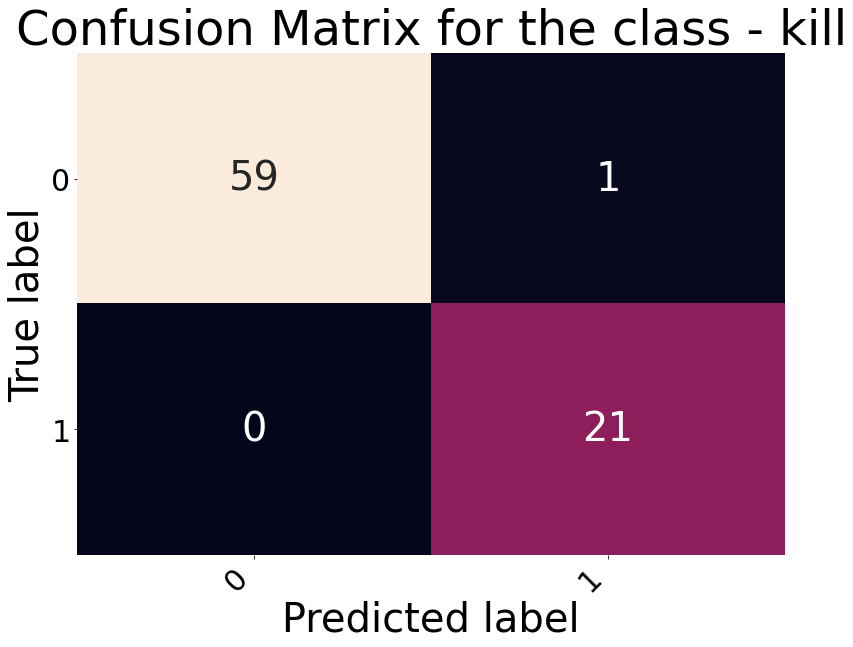

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

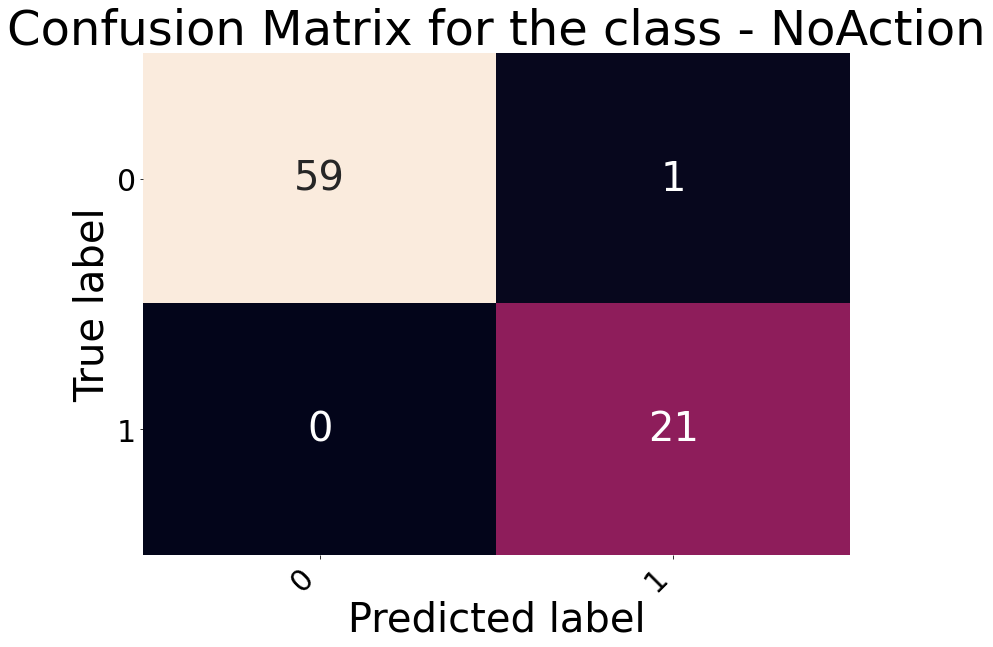

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

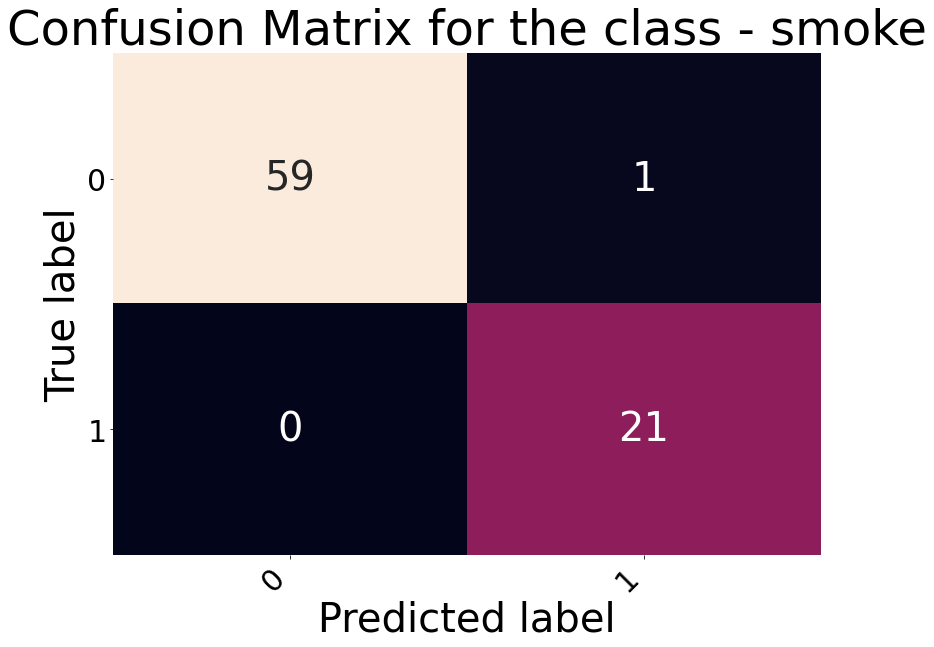

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Model of Each Tranfer Learning

In [108]:
#vgg16
model_vgg16 = Sequential()
model_vgg16.add(Dense(512, activation='relu', input_shape=(25088,)))
model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(512, activation='relu'))
#model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model_vgg16.add(Dense(64, activation='relu'))
#model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(4, activation='softmax'))
model_vgg16.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_vgg16.summary()

#xception
model_xception = Sequential()
model_xception.add(Dense(512, activation='relu', input_shape=(100352,)))
model_xception.add(Dropout(0.5))
#model_xception.add(Dense(512, activation='relu'))
#model_xception.add(Dropout(0.5))
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(128, activation='relu'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(4, activation='softmax'))
model_xception.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_xception.summary()

#inception
model_inception = Sequential()
model_inception.add(Dense(1024, activation='relu', input_shape=(51200,)))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(512, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(128, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(4, activation='softmax'))
model_inception.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_inception.summary()

#inception_resnet_v2
model_inception_resnet_v2 = Sequential()
model_inception_resnet_v2.add(Dense(512, activation='relu', input_shape=(38400,)))
model_inception_resnet_v2.add(Dropout(0.5))
#model_inception_resnet_v2.add(Dense(512, activation='relu'))
#model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(256, activation='relu'))
model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(128, activation='relu'))
model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(4, activation='softmax'))
model_inception_resnet_v2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_inception_resnet_v2.summary()

#resnet_v2
model_resnet_v2 = Sequential()
model_resnet_v2.add(Dense(512, activation='relu', input_shape=(100352,)))
model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(512, activation='relu'))
#model_resnet_v2.add(Dropout(0.1))
model_resnet_v2.add(Dense(256, activation='relu'))
model_resnet_v2.add(Dropout(0.5))
model_resnet_v2.add(Dense(128, activation='relu'))
model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(64, activation='relu'))
#model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(32, activation='relu'))
#model_resnet_v2.add(Dropout(0.5))
model_resnet_v2.add(Dense(4, activation='softmax'))
model_resnet_v2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_resnet_v2.summary()